In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from miniscope.imagingIO import loopMice, loadData, loadBeh, getBeh
from miniscope.analysis import dffCalc, filtData, smoothData, normData
from miniscope.events import getEvents
from miniscope.trials import markTrials
from miniscope.bouts import getBouts, getBoutDur, getBouts_
from miniscope.statistics import stdCalc, getBoutMeans, getStats, getBoutMeans_
from miniscope.plotter import plotMean, plotHeat, plotTrials, plotHeatTrials

In [12]:
# Start gathering the data from FR1 exp
# Mouse IDs and dataset IDs
mice = [(6838, 1), (6874, 1), (7104, 1), (7105, 1)]
# Parameters
# Behavior type
behType = 'FF'
# Imaging frame rate
fs = 0.05
# Which trials to include
trials=[1,2]
# Do you want to save?
save = False

In [13]:
# Get file paths for imaging data and behavior timestamps
fileList = loopMice(mice, behType)

# Load the imaging data
dataList = loadData(mice, behType)

# Load the behaviour timestamps
eventList = getBeh(mice, fileList['Behaviour'], behType)

# FIlter and dFF
filtList = filtData(mice, dffCalc(mice, dataList, lowest=True), cutoff=3.0, order=6)
dFFList = smoothData(mice, filtList, window=5)

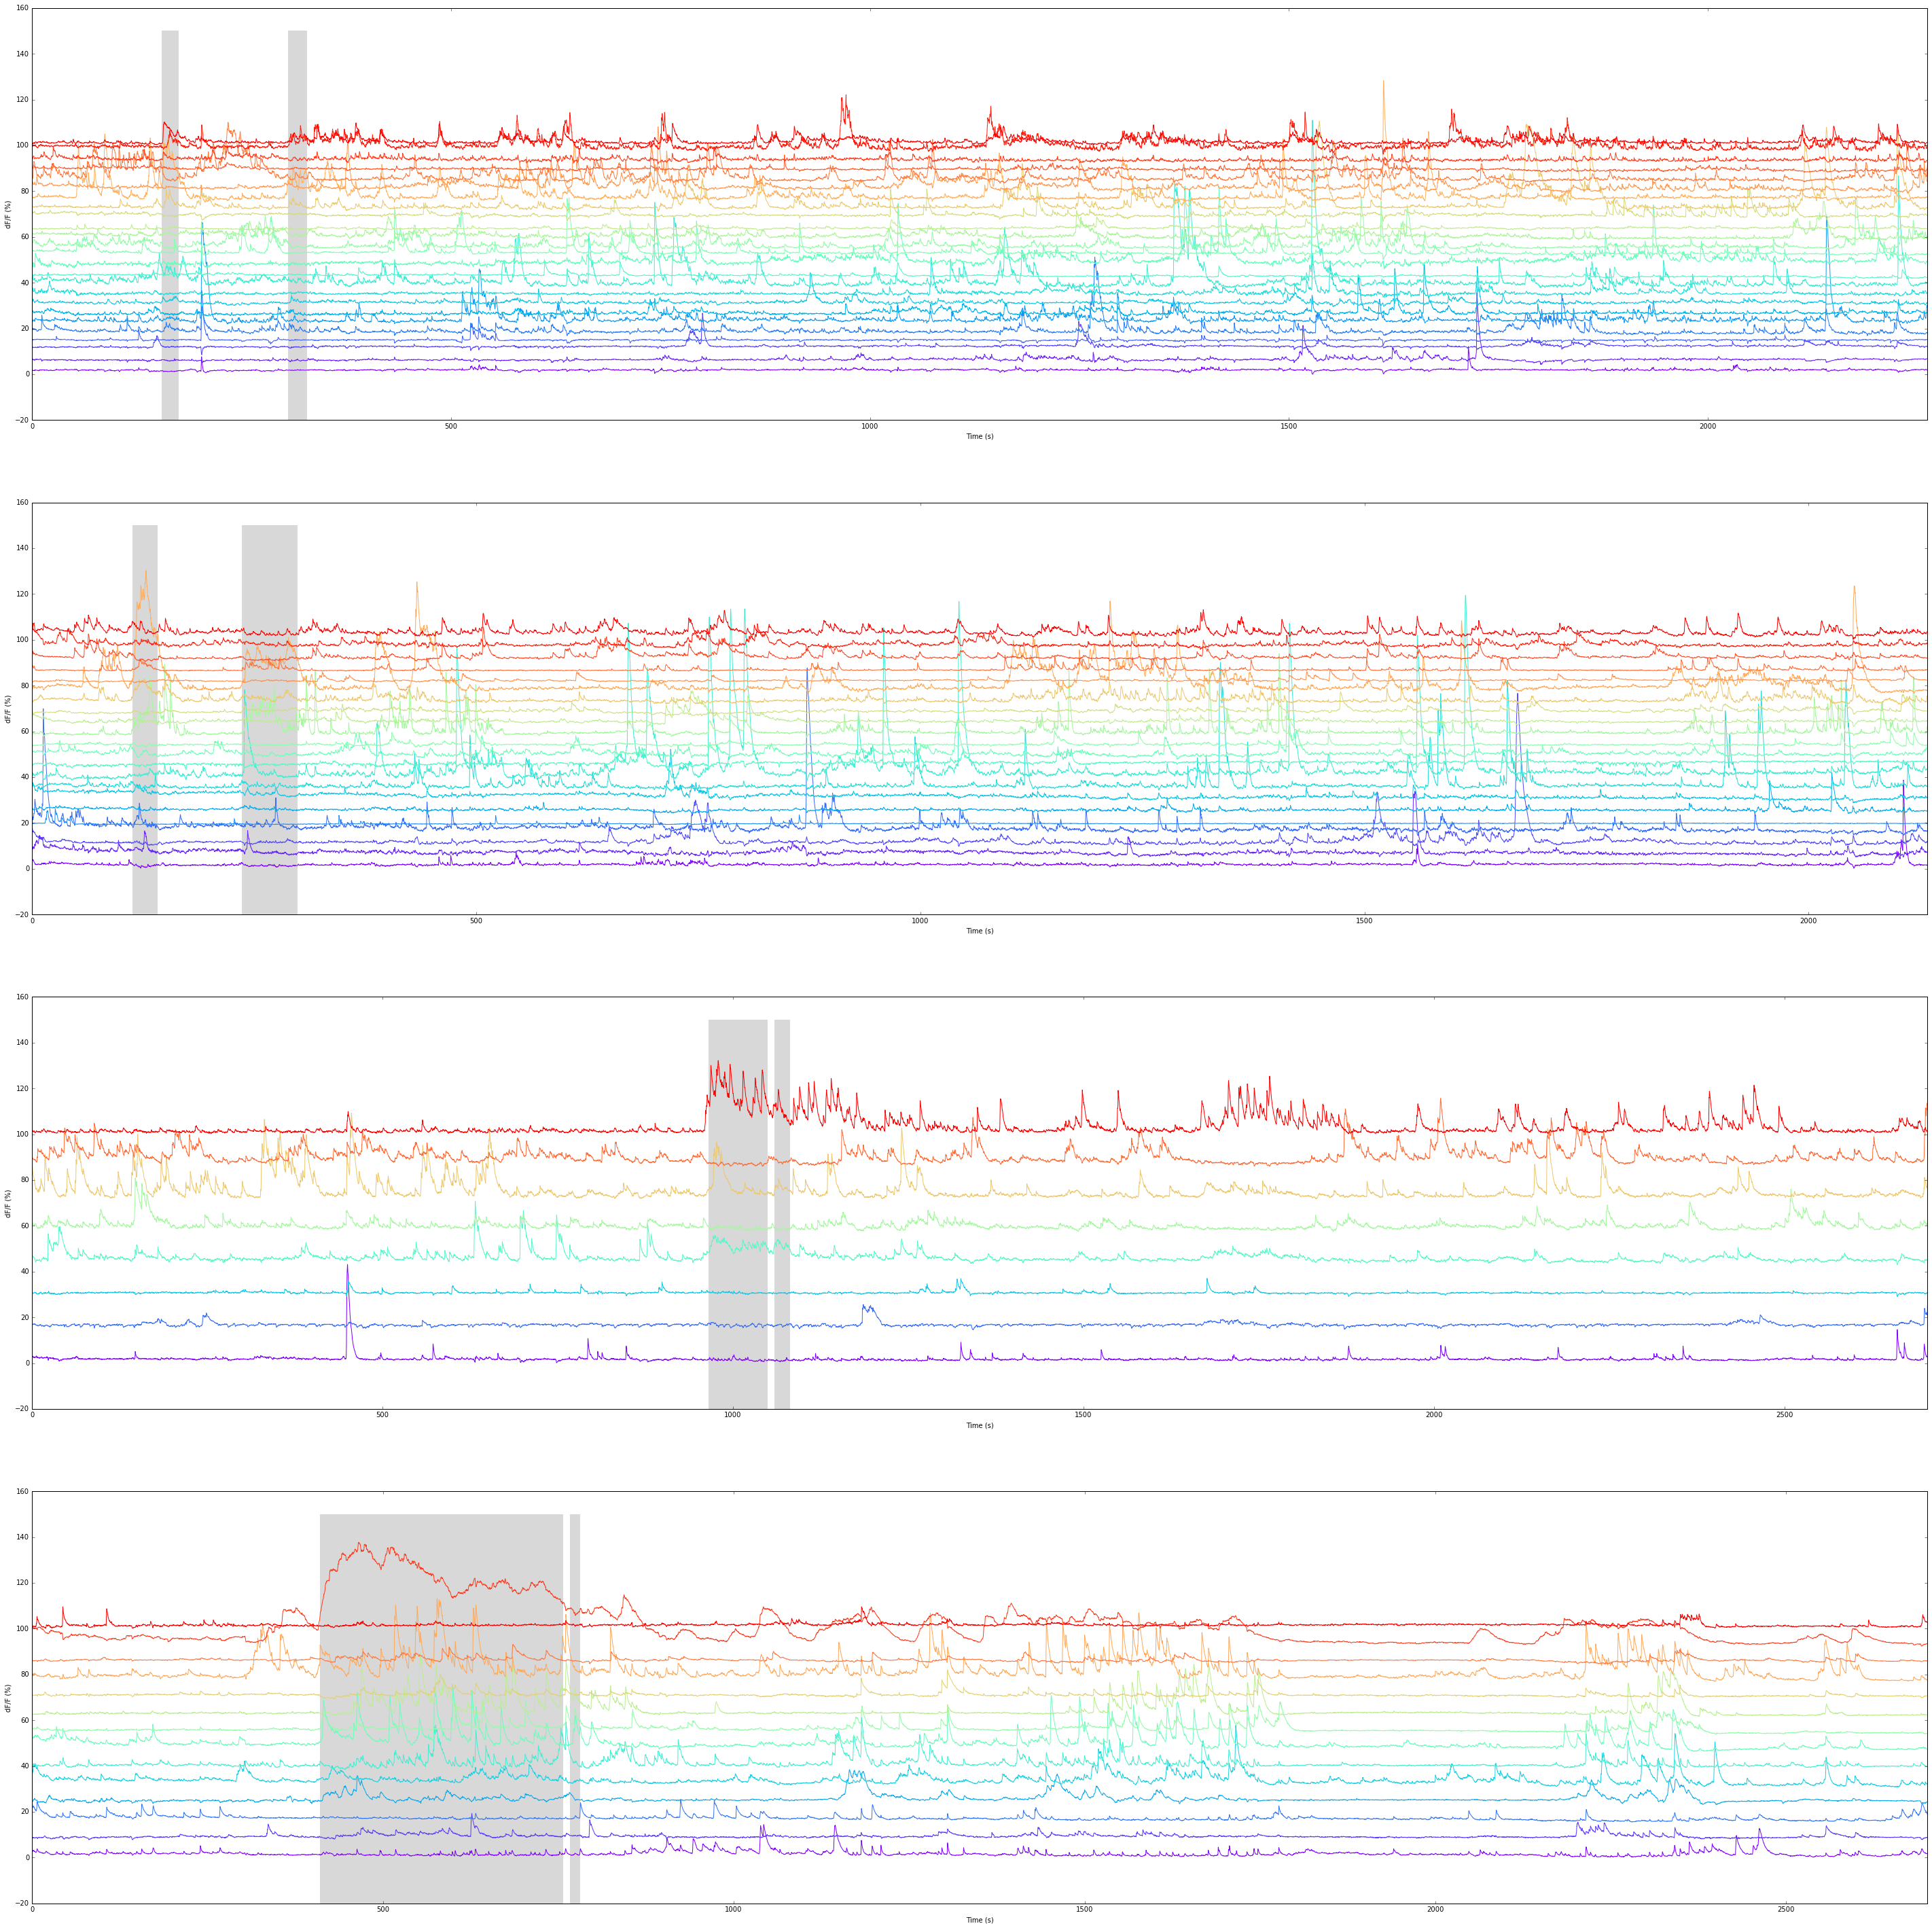

In [4]:
# Normalize the data
normList = normData(mice, dFFList)

# Get the events
eventStart = getEvents(mice, eventList, 'Eating_Start', trials)
eventEnd = getEvents(mice, eventList, 'Eating_End', trials)

# Plot the dFF data
n = 100
fig = plt.figure(figsize=(50,50), facecolor="w", dpi= 150)
for i, [mus, sess] in enumerate(mice):    
    offset = np.linspace(0, n, len(dFFList[mus].columns))
    ax = plt.subplot(len(mice),1,i+1)
    (dFFList[mus]+offset).plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
    ax.set_ylabel("dF/F (%)")

    # Plot the eating bouts
    for i, event in enumerate(eventStart[mus]):
        ax.fill_between([eventStart[mus].loc[i+1], eventEnd[mus].loc[i+1]], -20, 150, facecolor='gray', linewidth=0, alpha=0.3, zorder=-55)

In [5]:
from events import find_nearest

for mus, sess in mice:
    eventList[mus]['Eating_Start'].dropna().values
    eventList[mus]['Eating_End'].dropna().values

    timeSeries=dFFList[mus].index.values

    start=np.array([])
    for t in eventList[mus]['Eating_Start'].dropna().values:
        ind, time=find_nearest(timeSeries,t)
        start=np.append(start, time)

    end=np.array([])
    for t in eventList[mus]['Eating_End'].dropna().values:
        ind, time=find_nearest(timeSeries,t)
        end=np.append(end, time)

    boutMeans=pd.DataFrame()
    for j, t in enumerate(start): 
        df=dFFList[mus].loc[start[j]:end[j]].mean().to_frame(name=j)
        boutMeans=pd.concat([df, boutMeans], axis=1)

    prestart=np.append(np.array([0.00]), end[:-1])
    preend=start
    preboutMeans=pd.DataFrame()
    for j, t in enumerate(start): 
        df=dFFList[mus].loc[prestart[j]:preend[j]].mean().to_frame(name=j)
        preboutMeans=pd.concat([df, preboutMeans], axis=1)
        
    fname="J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\FF-bout_data\\boutmeans_"+str(mus)+".csv"
    if save:
        boutMeans.to_csv(fname)

    fname="J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\FF-bout_data\\preboutmeans_"+str(mus)+".csv"
    if save:
        preboutMeans.to_csv(fname)

In [21]:
fname="J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\scripts\\FF_boutmeans_Up\\upcells_boutsmeans"

In [6]:
# Pick the event
save = False
eventType = 'Eating_Start'
base = -40.0
duration = 40.0

# Find the marked events
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=False)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[1]

heatTrials = pd.DataFrame()
for ind in np.arange(trials[0], trials[1]+1):
    heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[ind]

    sortAx = heatData.mean(axis=1)
    heatData
    heatData['Cell_Mean'] = sortAx
    heatData = heatData.sort_values(by='Cell_Mean', ascending=False)

    heatTrials = heatTrials.append(heatData['Fluoro'])
    
sortAx = heatData.mean(axis=1)
heatData['Cell_Mean'] = sortAx
heatData = heatData.sort_values(by='Cell_Mean', ascending=False)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
if save:
    fig.savefig(fname)



4  mice were loaded.

4  mice were loaded.


(<matplotlib.figure.Figure at 0x19506208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19659a58>)

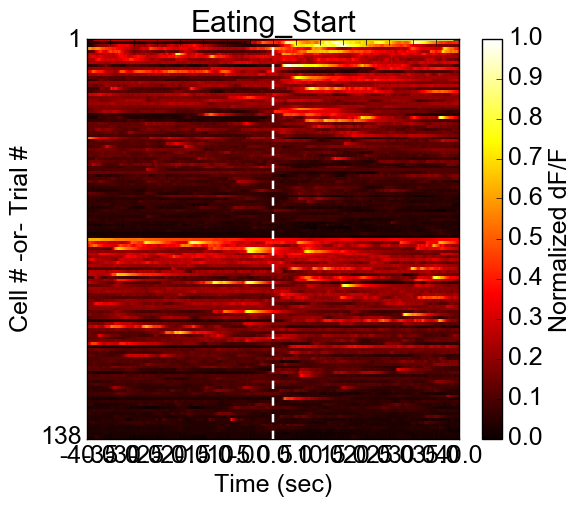

In [7]:
plotHeatTrials(heatTrials, eventType, base, duration, trials, fs=0.05, figsize=(6,5), seperate=False, vmin=0.0, vmax=1.0)

In [8]:
heatFirst=pd.DataFrame(heatTrials.values[:69, :]).T
sorter=heatFirst.loc[800:].mean(axis=0)
#sorter.sort_values(by=[sorter.index], ascending=False)

heatFirst = heatFirst.append(sorter, ignore_index=True).T
heatSort=heatFirst.sort_values(by=[1600], ascending=False).drop(1600, 1)

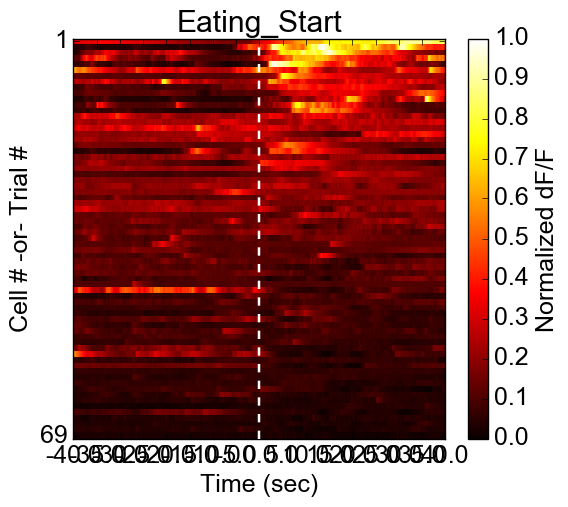

In [9]:
fig, ax = plotHeatTrials(heatSort, eventType, base, duration, trials, fs=0.05, figsize=(6,5), seperate=False, vmin=0.0, vmax=1.0)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\heatmap_options\\new_heatmaps\\"+"FF_magenta"+eventType+"_everything_heatmap_"+str(base)+"40sec_firstBout.pdf"
if save:
    fig.savefig(fname)